In [1]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 2.1 MB 28.7 MB/s 
     |████████████████████████████████| 18.3 MB 55 kB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

In [3]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [4]:
class ReplayBuffer():
  def __init__(self, max_size, input_shape):
    self.mem_size = max_size
    self.mem_cntr = 0

    self.state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
    self.new_state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
    self.log_prob_memory = np.zeros(self.mem_size, dtype=np.float32)
    self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
    self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

  def store_transition(self, state, log_prob, reward, state_, done):
    index = self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = state_
    self.log_prob_memory[index] = log_prob
    self.reward_memory[index] = reward
    self.terminal_memory[index] = done

    self.mem_cntr += 1

  def sample_buffer(self, batch_size):
    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, batch_size, replace=False)
    
    states = self.state_memory[batch]
    probs = self.log_prob_memory[batch]
    rewards = self.reward_memory[batch]
    states_ = self.new_state_memory[batch]
    dones = self.terminal_memory[batch]

    return states, probs, rewards, states_, dones


In [5]:
class ActorCriticNetwork(nn.Module):
  def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
    super(ActorCriticNetwork, self).__init__()

    self.input_dims = input_dims
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions

    self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
    self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
    self.pi = nn.Linear(self.fc2_dims, self.n_actions)
    self.v = nn.Linear(self.fc2_dims, 1)

    self.optimizer = optim.Adam(self.parameters(), lr = lr)

    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    fc1 = F.relu(self.fc1(state))
    fc2 = F.relu(self.fc2(fc1))
    pi = self.pi(fc2)
    v = self.v(fc2)

    return (pi, v)

In [6]:
class Agent():
  def __init__(self, lr, input_dims, n_actions, gamma=0.99, l1_size = 256, 
               l2_size = 256, batch_size = 32, mem_size = 10000):
    self.gamma = gamma
    self.batch_size = batch_size
    self.memory = ReplayBuffer(mem_size, input_dims)
    self.actor_critic = ActorCriticNetwork(lr, input_dims, l1_size, l2_size, 
                                           n_actions = n_actions)
    
  def store_transition(self, state, prob, reward, state_, done):
    self.memory.store_transition(state, prob, reward, state_, done)
  
  def choose_action(self, observation):
    state = T.tensor([observation]).to(self.actor_critic.device)
    probabilities, _ = self.actor_critic.forward(state)
    probabilities = F.softmax(probabilities)
    action_probs = T.distributions.Categorical(probabilities)
    action = action_probs.sample()
    log_probs = action_probs.log_prob(action)

    return action.item(), log_probs

  def learn(self):
    if self.memory.mem_cntr < self.batch_size:
      return

    self.actor_critic.optimizer.zero_grad()

    state, prob, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
    states = T.tensor(state).to(self.actor_critic.device)
    probs = T.tensor(prob).to(self.actor_critic.device)
    rewards = T.tensor(reward).to(self.actor_critic.device)
    dones = T.tensor(done).to(self.actor_critic.device)
    states_ = T.tensor(new_state).to(self.actor_critic.device)

    _, critic_value = self.actor_critic.forward(states)
    _, critic_value_ = self.actor_critic.forward(states_)

    critic_value_[dones] = 0.0

    delta = rewards + self.gamma*critic_value_

    actor_loss = -T.mean(probs*(delta - critic_value))
    critic_loss = F.mse_loss(delta, critic_value)

    (actor_loss + critic_loss).backward()
    self.actor_critic.optimizer.step()

    



In [8]:
env = gym.make('CartPole-v1')
agent = Agent(gamma=0.99, lr=5e-6, input_dims=[4], n_actions=2, l1_size=2048, l2_size=1536)
n_games = 1000

scores = []

for i in range(n_games):
  done = False
  observation = env.reset()
  score = 0

  while not done:
    action, prob = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    score += reward
    agent.store_transition(observation, prob, reward, observation_, int(done))

    agent.learn()
    observation = observation_

    scores.append(score)

    avg_score = np.mean(scores[-100:])

    print('episode ', i, 'score %.1f' % score,'average score %.1f' % avg_score)
    



/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/ipy

episode  0 score 1.0 average score 1.0
episode  0 score 2.0 average score 1.5
episode  0 score 3.0 average score 2.0
episode  0 score 4.0 average score 2.5
episode  0 score 5.0 average score 3.0
episode  0 score 6.0 average score 3.5
episode  0 score 7.0 average score 4.0
episode  0 score 8.0 average score 4.5
episode  0 score 9.0 average score 5.0
episode  0 score 10.0 average score 5.5
episode  0 score 11.0 average score 6.0
episode  0 score 12.0 average score 6.5
episode  1 score 1.0 average score 6.1
episode  1 score 2.0 average score 5.8
episode  1 score 3.0 average score 5.6
episode  1 score 4.0 average score 5.5
episode  1 score 5.0 average score 5.5
episode  1 score 6.0 average score 5.5
episode  1 score 7.0 average score 5.6
episode  1 score 8.0 average score 5.7
episode  1 score 9.0 average score 5.9
episode  1 score 10.0 average score 6.0
episode  1 score 11.0 average score 6.3
episode  1 score 12.0 average score 6.5
episode  1 score 13.0 average score 6.8
episode  1 score 1

/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:1239.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Streaming output truncated to the last 5000 lines.
episode  773 score 8.0 average score 18.0
episode  773 score 9.0 average score 17.9
episode  773 score 10.0 average score 17.9
episode  773 score 11.0 average score 17.9
episode  773 score 12.0 average score 17.9
episode  773 score 13.0 average score 17.9
episode  773 score 14.0 average score 17.9
episode  774 score 1.0 average score 17.8
episode  774 score 2.0 average score 17.6
episode  774 score 3.0 average score 17.4
episode  774 score 4.0 average score 17.3
episode  774 score 5.0 average score 17.1
episode  774 score 6.0 average score 17.0
episode  774 score 7.0 average score 16.9
episode  774 score 8.0 average score 16.7
episode  774 score 9.0 average score 16.6
episode  774 score 10.0 average score 16.4
episode  774 score 11.0 average score 16.2
episode  775 score 1.0 average score 16.0
episode  775 score 2.0 average score 15.7
episode  775 score 3.0 average score 15.5
episode  775 score 4.0 average score 15.2
episode  775 score

Done


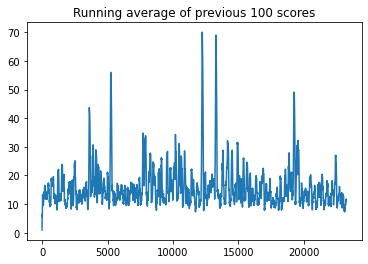

In [9]:
fname = 'actor_critic_naive_experience_replay_cartpole'
figure_file = fname + '.png'
csv_file = fname +'.csv'

x = [i+1 for i in range(len(scores))]
plot_learning_curve(x, scores, figure_file)

with open(csv_file, 'w') as fp:
    for item in scores:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')